## What determines the variance of the rebound time?

The first reactivation event is exponentially distributed with rate parameter $\lambda$.
If the recrudescence rate is small compared to the growth rate $g$, the rebound time
is going to be determined (almost) completely by the first recrudescence time. 
If $\lambda$ is large compaed to $g$, then secondary reactivation times with influence 
the distribution of the rebound time.

Here we look at what proportion of the variance in the rebound time $\tau$ is explained by
the first recrudescence event, and what proportion by the secondary events.

In [1]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import pickle
from multiprocessing import Pool
import scipy
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import blended_transform_factory
import os

import sys
sys.path.append("..")
from mrmpytools.stats import fpt_rng, fpt_pdf

In [2]:
plt.rcParams.update({'font.size': 18})

## Test random number generator

In `mrmpytools.stats` we define a function `fpt_rng` that can be used 
to sample from the diffusion approximation of the rebound time distribution.
Here we first test this random number generator.

We first take a large sample from the distribution, and then compare 
a histogram of this sample with the PDF of the distribution.

Text(0, 0.5, 'density')

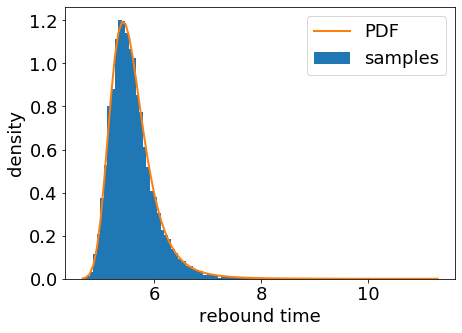

In [3]:
ell = 50
lam = 1
v0 = 0.1
g = 1
V0 = v0

xs = [fpt_rng(ell, lam, v0, g, V0) for _ in range(10000)]

fig, ax = plt.subplots(1, 1, figsize=(7,5))

ts = np.linspace(np.min(xs), np.max(xs), 100)

fs = [fpt_pdf(t, ell, lam, v0, g, V0) for t in ts]

ax.hist(xs, bins=100, density=True, label="samples")
ax.plot(ts, fs, label="PDF", linewidth=2)

ax.legend()

ax.set_xlabel("rebound time")
ax.set_ylabel("density")

## "Analysis of Variance" of the multiple-reactivation model

We compute the variace by sampling from the rebound-time distribution, therefore **this may take some time** 

In [4]:
## do a "parameter sweep" and compute variances by sampling

lams = np.logspace(-1.5, 1, 50, base=10)
gs = np.linspace(0.1, 2.5, 50)

Xs = np.zeros((len(gs), len(lams)))
J = 1000 ## 10000

jobs = [(i, j, lam, g, ell, v0, J, np.random.randint(2**32)) 
        for i, lam in enumerate(lams) 
        for j, g in enumerate(gs)]

def calc_vars(i, j, lam, g, ell, v0, J, seed):
    scipy.random.seed(seed)
    ## V0 = 0: includes first reactivation event
    #taus = [fpt_rng(ell, lam, v0, g, 0.0) for _ in range(J)]
    taus = [fpt_rng(ell, lam, v0, g, v0) + sts.expon.rvs(scale=1/lam) for _ in range(J)]
    full_var = np.var(taus)
    ## V0 = v0: exclude first reactivation event
    taus = [fpt_rng(ell, lam, v0, g, v0) for _ in range(J)]
    partial_var = np.var(taus)
    return i, j, partial_var / full_var

xx, yy = np.meshgrid(lams, gs)

with Pool() as pool:
    results = pool.starmap(calc_vars, jobs)
    
for i, j, X in results:
    Xs[j, i] = X

### For the figure below, we have to import some of the estimates

We import estimates of $\lambda$ and $g$ from the early-treated macaque data set. 
The estimates are loaded from the "pickles"

- `estimates-rebound.pkl`
- `estimates-acute.pkl`

These were calculated in other notebooks:

- `FitStanModels.ipynb` 
- `FitAcuteStanModel.ipynb`

In addition, we need the ART initiation times. We get them form the "pickle"

- `rebound-data.ipynb`

In [5]:
## import estimates from the Whitney dataset

estimate_pickle = os.path.join("..", "data", "estimates-rebound.pkl")
with open(estimate_pickle, 'rb') as f:
    estimate_dicts = pickle.load(f)

## import estimates from the Whitney dataset of acute infection

acute_estimate_pickle = os.path.join("..", "data", "estimates-acute.pkl")
with open(acute_estimate_pickle, 'rb') as f:
    acute_estimate_dicts = pickle.load(f)

## import the rebound data set to get ART init times

data_pickle = os.path.join("..", "data", "rebound-data.pkl")
with open(data_pickle, 'rb') as f:
    data_dicts = pickle.load(f)

IDs = sorted(list(data_dicts.keys()))

## Figure 4

In panel A and B we show the estimates of $\lambda$ and $g$, as a function of ART initiation time.
Panel C shows a heatmap of the percentage of the variance in rebound time that is explained by secondary recrudescence events. On top of the heatmap, we show the estimates from our data set again.

Text(-0.3, 1.01, 'B')

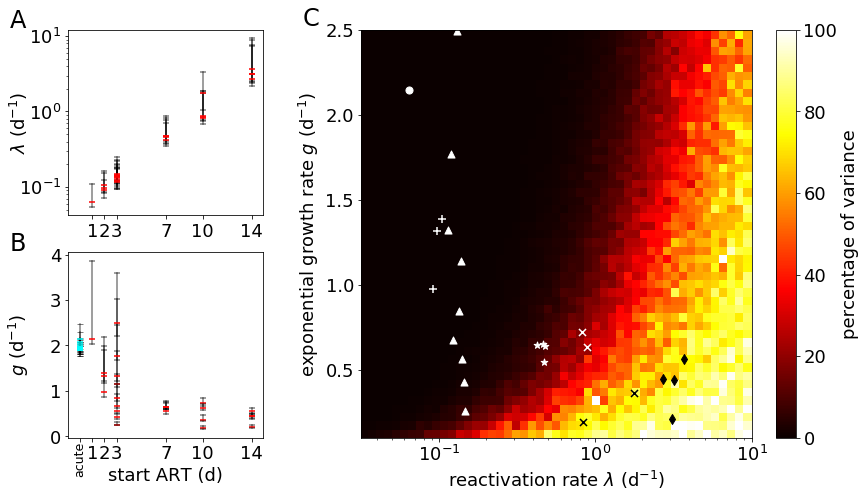

In [7]:
fig = plt.figure(figsize=(14,7.5))

gspc = GridSpec(2,3)
gspc.update(wspace=0.5)

## flip the panels: first bx1, bx2, then ax
ax = fig.add_subplot(gspc[:,1:3])

C = ax.pcolormesh(lams, gs, 100*Xs, vmin=0, vmax=100, cmap='hot', 
                  linewidth=0, rasterized=True)
C.set_edgecolor('face')
cx = fig.colorbar(C)

ax.set_xlabel("reactivation rate $\\lambda$ ($\\mathsf{d}^{-1}$)")
ax.set_ylabel("exponential growth rate $g$ ($\\mathsf{d}^{-1}$)")
ax.set_xscale('log')
cx.set_label("percentage of variance")

## put estimates in the figure

spline = scipy.interpolate.RectBivariateSpline(lams, gs, Xs.T)

marker_dict = {
    1 : 'o',
    2 : '+',
    3 : '^',
    7 : '*',
    10 : 'x',
    14 : 'd'
}

tARTs = {ID : data_dicts[ID]["StartART"] for ID in IDs}
for ID in IDs:
    ## g is called r in the other notebook...
    g = estimate_dicts[ID]["r_mode"]
    lam = estimate_dicts[ID]["lambda_mode"]
    dd = data_dicts[ID]
    tART = tARTs[ID]
    bg = spline(lam, g)
    color = 'k' if bg > 0.4 else 'w'
    ax.scatter([lam], [g], color=color, marker=marker_dict[tART], s=50)

ax.set_xlim(np.min(lams), np.max(lams))
ax.set_ylim(np.min(gs), np.max(gs))
    
## panel for lambda and g as a function ot tART

bx1 = fig.add_subplot(gspc[0,0])
xs = np.array([tARTs[ID] for ID in IDs])
bx1.scatter(xs, [estimate_dicts[ID]["lambda_mode"] for ID in IDs], 
            color='r', marker='_', zorder=2)
for i, ID in enumerate(IDs):
    x = xs[i]
    bx1.plot([x, x], estimate_dicts[ID]["lambda_CrI50"], 
             color='k', alpha=0.5, zorder=1)
    bx1.scatter([x, x], estimate_dicts[ID]["lambda_CrI50"], 
                color='k', alpha=0.5, marker='_', zorder=1)

bx2 = fig.add_subplot(gspc[1,0])
bx2.scatter([tARTs[ID] for ID in IDs], [estimate_dicts[ID]["r_mode"] for ID in IDs], 
            color='r', marker='_', zorder=2)
for ID in IDs:
    bx2.plot([tARTs[ID], tARTs[ID]], estimate_dicts[ID]["r_CrI50"], 
             color='k', alpha=0.5, zorder=1)
    bx2.scatter([tARTs[ID], tARTs[ID]], estimate_dicts[ID]["r_CrI50"], 
                color='k', alpha=0.5, marker='_', zorder=2)

## add estimates of the acute growth rate to bx2

for ID in IDs:
    if ID in acute_estimate_dicts.keys():
        bx2.plot([0, 0], acute_estimate_dicts[ID]["r_CrI50"],
                color='k', alpha=0.5, zorder=1, marker='_')
        bx2.scatter([0], acute_estimate_dicts[ID]["r_mode"],
                   color='cyan', marker='_', zorder=2)
        
    
bx1.set_yscale('log')    

bx2.set_xlabel("start ART (d)")

xticks = [1,2,3,7,10,14]

bx2.set_xticks([0] + xticks)
bx2.set_xticklabels([''] + xticks)

bx1.set_xticks(xticks)
bx1.set_xlim(bx2.get_xlim())

## add a tick for bx2 to indicate the acute slopes

trans = blended_transform_factory(bx2.transData, bx2.transAxes)

bx2.annotate("acute", xy=(0,0), xytext=(0, -0.02), 
             textcoords=trans, xycoords=trans, 
             rotation=90, ha='center', va='top', fontsize='x-small')

bx1.set_ylabel("$\\lambda$ ($\\mathsf{d}^{-1}$)", va='center')
bx2.set_ylabel("$g$ ($\\mathsf{d}^{-1}$)", va='center')

## manually adjust ylabel coords
labelx = -0.25  # axes coords
for bx in [bx1, bx2]:
    bx.yaxis.set_label_coords(labelx, 0.5)

## labels for panels

ax.text(-0.15, 1.01, "C", fontsize=24, transform=ax.transAxes)

bx1.text(-0.3, 1.01, "A", fontsize=24, transform=bx1.transAxes)
bx2.text(-0.3, 1.01, "B", fontsize=24, transform=bx2.transAxes)


#fig.savefig("../Figure4.pdf", bbox_inches='tight')